In [393]:
import lyricsgenius as lg
import re
import inspect
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB as NB
from sklearn.naive_bayes import BernoulliNB
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import cm
import itertools
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import time

#Helper Function for calculating computation times
def timer_start():
    global start
    start = time.time()
def timer_end():
    end = time.time()
    print("Time Spent: " + str(round(end - start, 2)) + " sec")

#Helper Function for creating confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Sample Confusion Matrix',
                          cmap=plt.cm.Greens):
    plt.imshow(cm, 
               interpolation='nearest', 
               cmap=cmap)
    plt.title(title, fontsize=26)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16,
               rotation = 45,
              )
    plt.yticks(tick_marks, classes, fontsize=16, rotation = 0, va="center")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i,j],2) ,fontsize=20,
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="gray")
    plt.tight_layout()
    plt.ylabel('Actual',fontsize=20)
    plt.xlabel('Prediction',fontsize=20)
    plt.colorbar()
    
#Function to calculate the sum of the diagonal of the confusion matrix
def DiagonalSum(mat):
    total = 0
    for i in range(0, len(mat)):
        total += mat[i][i]
    return(total)

In [3]:
%run vectorize.py

In [394]:
tfidfVecDF = pd.read_csv("tf_idf_vectorized.csv")
countVecDF = pd.read_csv("term_frequency_vectorized.csv")
binaryVecDF = pd.read_csv("binarized.csv")

In [395]:
countVecDF[countVecDF['LABEL'].isin(['EXCLUDE', 'JAMAICA', 'AUS'])]

,LABEL,01,02,03,04,05,06,07,08,09,...,zoned,zonin,zoning,zoom,zoomed,zooms,zoot,zoowap,zsa,zumbi
121,AUS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122,AUS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,EXCLUDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185,JAMAICA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,EXCLUDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,JAMAICA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,JAMAICA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,JAMAICA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281,EXCLUDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [396]:
labels = countVecDF['LABEL']
multiList = []
for label in labels:
    if label.find(',') > 0:
        multiList.append(True)
    else:
        multiList.append(False)
print(sum(multiList))
multipleRegionsDF = countVecDF[multiList]

23


In [397]:
excludeIndex = countVecDF[countVecDF['LABEL'].isin(['EXCLUDE', 'JAMAICA', 'AUS', 'CAN', 'EU'])].index
multiIndex = countVecDF[multiList].index
dropIndex = excludeIndex.union(multiIndex)

cleanBinVecDF = binaryVecDF.drop(dropIndex)
cleanCountVecDF = countVecDF.drop(dropIndex)
cleanTfidfVecDF = tfidfVecDF.drop(dropIndex)
cleanTfidfVecDF

,LABEL,01,02,03,04,05,06,07,08,09,...,zoned,zonin,zoning,zoom,zoomed,zooms,zoot,zoowap,zsa,zumbi
1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,GA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326,LA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327,GA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [398]:
## DICTIONARY TO CONVERT STATE TO REGION ##
regionDict = {'CA': 'West Coast', 
              'NY': 'East Coast', 
              'LA': 'South', 
              'FL': 'South', 
              'MD': 'East Coast', 
              'GA': 'South', 
              'OH': 'Midwest', 
              'MI': 'Midwest', 
              'TX': 'South', 
              'MO': 'Midwest', 
              'NJ': 'East Coast', 
              'WI': 'Midwest', 
              'IL': 'Midwest', 
              'PA': 'East Coast', 
              'CAN': 'Canada', 
              'MA': 'East Coast', 
              'WA': 'West Coast', 
              'VA': 'East Coast', 
              'EU': 'Europe', 
              'DC': 'East Coast', 
              'NC': 'East Coast', 
              'MS': 'South'}

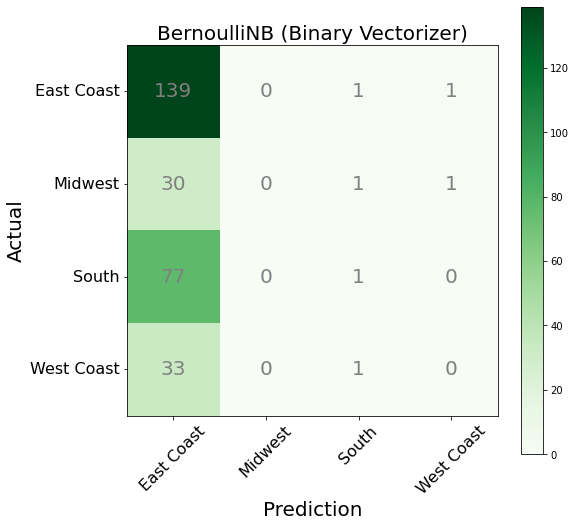

Overall Accuracy: 49.12%
Time Spent: 2.1 sec


In [432]:
### BINARY VECTORIZER + BERNOULLI NB MODEL ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = BernoulliNB(alpha=1)

vecData = cleanBinVecDF.drop(["LABEL"], axis=1)
regionLabels = cleanBinVecDF['LABEL'].copy()
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
vecLabels = regionLabels
y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('BernoulliNB (Binary Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

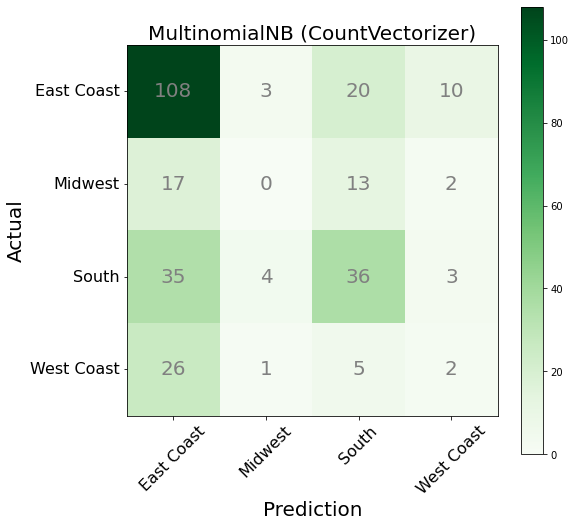

Overall Accuracy: 51.23%
Time Spent: 1.15 sec


In [433]:
### COUNT VECTORIZER + MULTINOMIAL NB MODEL ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = NB(alpha=1)

vecData = cleanCountVecDF.drop(["LABEL"], axis=1)
regionLabels = cleanCountVecDF['LABEL'].copy()
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
vecLabels = regionLabels
y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('MultinomialNB (CountVectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

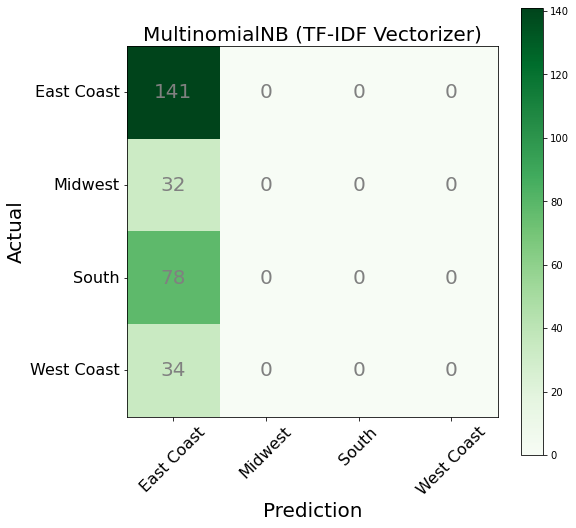

Overall Accuracy: 49.47%
Time Spent: 0.97 sec


In [434]:
### TF-IDF VECTORIZER + MULTINOMIAL NB MODEL ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = NB(alpha=1)

vecData = cleanTfidfVecDF.drop(["LABEL"], axis=1)
regionLabels = cleanTfidfVecDF['LABEL'].copy()
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
vecLabels = regionLabels
y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('MultinomialNB (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

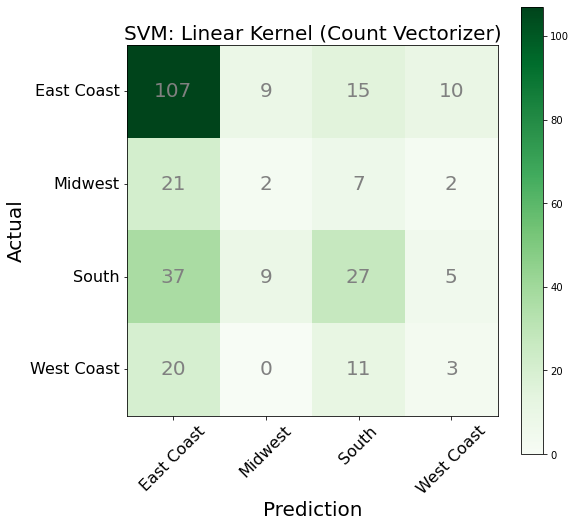

Overall Accuracy: 48.77%
Time Spent: 0.87 sec


In [435]:
### COUNT VECTORIZER + SVM MODEL (LINEAR KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)

SVM_Model_Linear = LinearSVC(C=1)

vecData = cleanCountVecDF.drop(["LABEL"], axis=1)
regionLabels = cleanCountVecDF['LABEL'].copy()
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
vecLabels = regionLabels

y_pred = cross_val_predict(SVM_Model_Linear, vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
linCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Linear Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

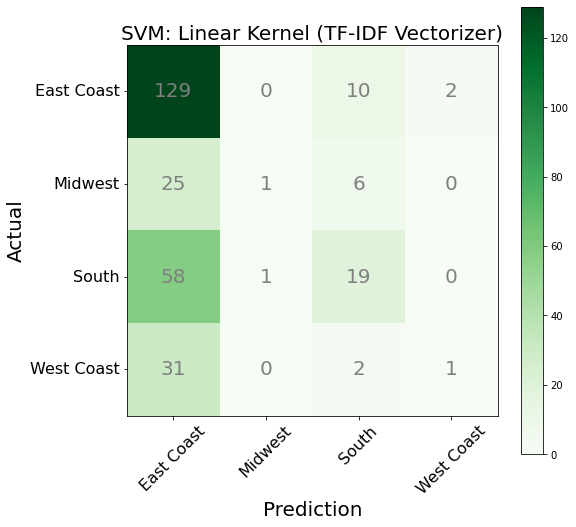

Overall Accuracy: 52.63%
Time Spent: 0.73 sec


In [436]:
### TF-IDF VECTORIZER + SVM MODEL (LINEAR KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)

SVM_Model_Linear = LinearSVC(C=1)

vecData = cleanTfidfVecDF.drop(["LABEL"], axis=1)
regionLabels = cleanTfidfVecDF['LABEL'].copy()
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
vecLabels = regionLabels

y_pred = cross_val_predict(SVM_Model_Linear, vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
linCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Linear Kernel (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

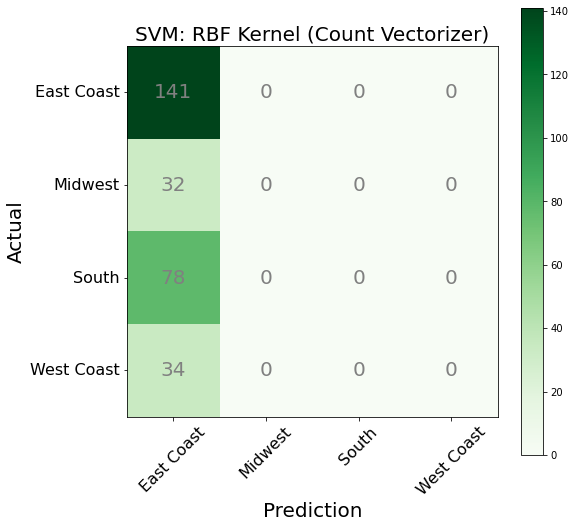

Overall Accuracy: 49.47%
Time Spent: 2.15 sec


In [437]:
### COUNT VECTORIZER + SVM MODEL (RBF KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Radial = sklearn.svm.SVC(C=1, kernel='rbf', verbose=True, gamma="auto")

vecData = cleanCountVecDF.drop(["LABEL"], axis=1)
regionLabels = cleanCountVecDF['LABEL'].copy()
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
vecLabels = regionLabels

y_pred = cross_val_predict(SVM_Model_Radial, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
rbfCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: RBF Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

In [405]:
##########
## SUBSAMPLE DATA SO THAT EACH REGION IS EQUALLY REPRESENTED ##
##########

## BINARY VECTORIZED SS (Subsample) ##

vecData = cleanBinVecDF.drop(["LABEL"], axis=1)
vecLabels = cleanBinVecDF['LABEL'].copy()
regionLabels = vecLabels
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
regionLabels.value_counts()

regionBinVecDF = vecData.copy()
regionBinVecDF.insert(0, 'LABEL', regionLabels)
small_dfs = []
for region in regionLabels.unique():
    tempDF = regionBinVecDF[regionBinVecDF['LABEL'] == region].copy()
    subDF = tempDF.sample(min(regionLabels.value_counts()), random_state = 42)
    small_dfs.append(subDF)
        
ssBinDF = pd.concat(small_dfs, ignore_index = True)
ssBinDF = ssBinDF.loc[:, (ssBinDF != 0).any(axis=0)]
#ssBinDF

,LABEL,01,04,06,10,100,101,102,103,104,...,zeros,zig,zip,zipper,zod,zombie,zone,zonin,zoom,zsa
0,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Midwest,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,Midwest,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,Midwest,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,Midwest,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [438]:
regionLabels.value_counts()

East Coast    141
South          78
West Coast     34
Midwest        32
Name: LABEL, dtype: int64

In [406]:
## COUNT VECTORIZED SS (Subsample) ##

vecData = cleanCountVecDF.drop(["LABEL"], axis=1)
vecLabels = cleanCountVecDF['LABEL'].copy()
regionLabels = vecLabels
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
#regionLabels.value_counts()

regionCountVecDF = vecData.copy()
regionCountVecDF.insert(0, 'LABEL', regionLabels)
small_dfs = []
for region in regionLabels.unique():
    tempDF = regionCountVecDF[regionCountVecDF['LABEL'] == region].copy()
    subDF = tempDF.sample(min(regionLabels.value_counts()), random_state = 42)
    small_dfs.append(subDF)
        
ssCountDF = pd.concat(small_dfs, ignore_index = True)
ssCountDF = ssCountDF.loc[:, (ssCountDF != 0).any(axis=0)]
ssCountDF

,LABEL,01,04,06,10,100,101,102,103,104,...,zeros,zig,zip,zipper,zod,zombie,zone,zonin,zoom,zsa
0,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,West Coast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Midwest,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,Midwest,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,Midwest,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,Midwest,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [407]:
## TF-IDF VECTORIZED SS (Subsample) ##

vecData = cleanTfidfVecDF.drop(["LABEL"], axis=1)
vecLabels = cleanTfidfVecDF['LABEL'].copy()
regionLabels = vecLabels
for index, label in enumerate(regionLabels):
    regionLabels.iloc[index] = regionDict.get(label)
#regionLabels.value_counts()

regionTfidfVecDF = vecData.copy()
regionTfidfVecDF.insert(0, 'LABEL', regionLabels)
small_dfs = []
for region in regionLabels.unique():
    tempDF = regionTfidfVecDF[regionTfidfVecDF['LABEL'] == region].copy()
    subDF = tempDF.sample(min(regionLabels.value_counts()), random_state = 42)
    small_dfs.append(subDF)
        
ssTfidfDF = pd.concat(small_dfs, ignore_index = True)
ssTfidfDF = ssTfidfDF.loc[:, (ssTfidfDF != 0).any(axis=0)]
ssTfidfDF

,LABEL,01,04,06,10,100,101,102,103,104,...,zeros,zig,zip,zipper,zod,zombie,zone,zonin,zoom,zsa
0,West Coast,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.042707,0.0,0.0,0.0
1,West Coast,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.020783,0.0,0.0,0.0
2,West Coast,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,West Coast,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,West Coast,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Midwest,0.0,0.0,0.0,0.02973,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
124,Midwest,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
125,Midwest,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
126,Midwest,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


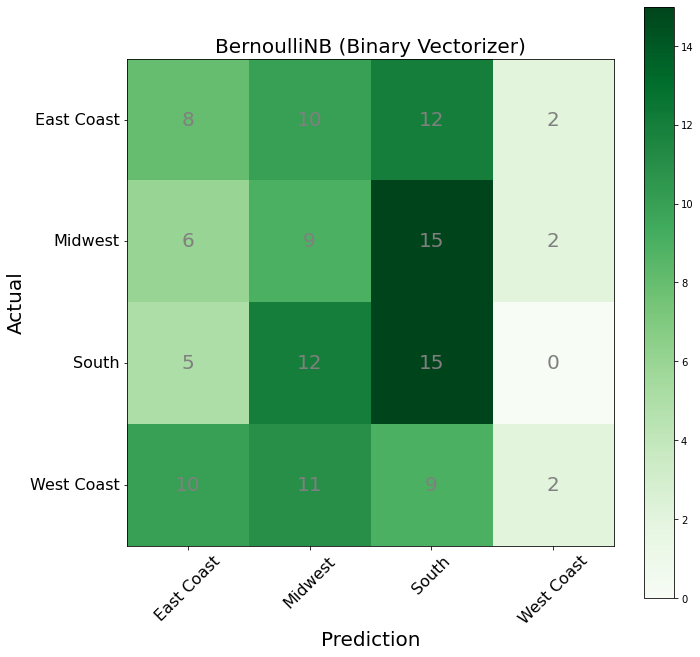

Overall Accuracy: 26.56%
Time Spent: 0.47 sec


In [408]:
### BINARY VECTORIZER + MULTINOMIAL NB MODEL ###
timer_start()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = BernoulliNB(alpha=1)

vecData = ssBinDF.drop(["LABEL"], axis=1)
vecLabels = ssBinDF["LABEL"].copy()

y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('BernoulliNB (Binary Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

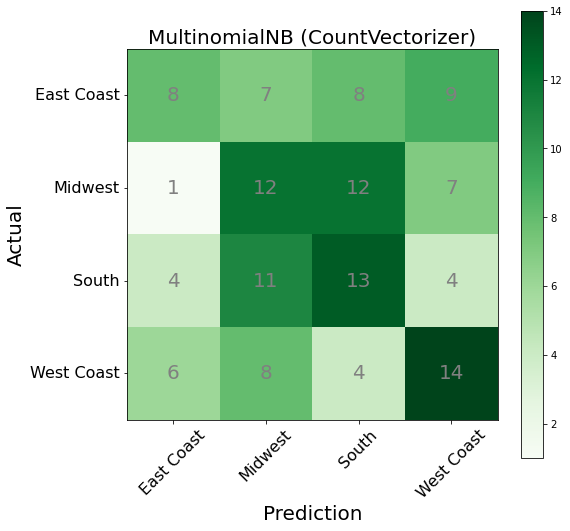

Overall Accuracy: 36.72%
Time Spent: 4.72 sec


In [439]:
### COUNT VECTORIZER + MULTINOMIAL NB MODEL ###
timer_start()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = NB(alpha=1)

vecData = ssCountDF.drop(["LABEL"], axis=1)
vecLabels = ssCountDF["LABEL"].copy()

y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(8,8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('MultinomialNB (CountVectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

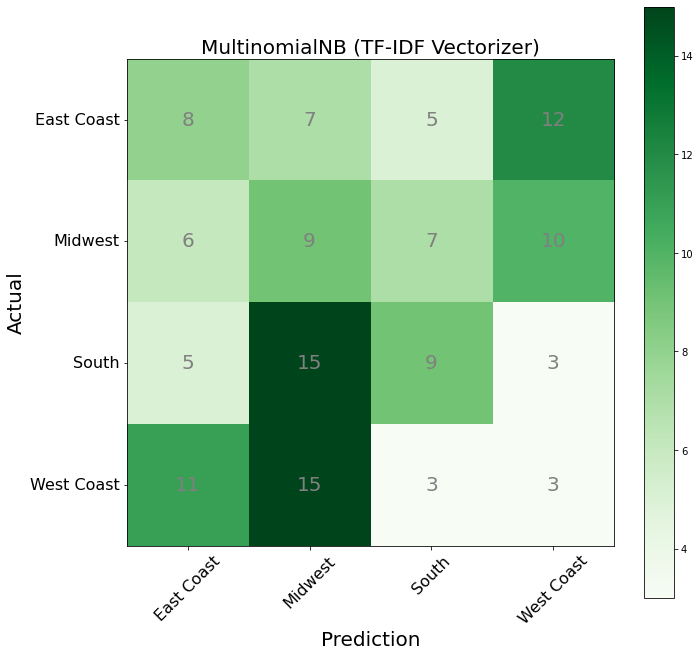

Overall Accuracy: 22.66%
Time Spent: 0.42 sec


In [410]:
### TF-IDF VECTORIZER + MULTINOMIAL NB MODEL ###
timer_start()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = NB(alpha=1)

vecData = ssTfidfDF.drop(["LABEL"], axis=1)
vecLabels = ssTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('MultinomialNB (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

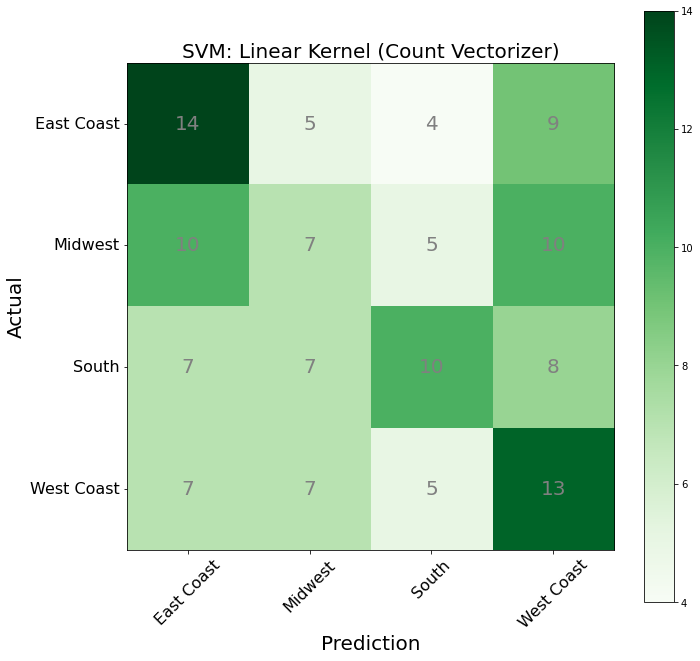

Overall Accuracy: 34.38%
Time Spent: 1.82 sec


In [427]:
### COUNT VECTORIZER + SVM MODEL (LINEAR KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)

SVM_Model_Linear = LinearSVC(C=1)

vecData = ssCountDF.drop(["LABEL"], axis=1)
vecLabels = ssCountDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Linear, vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
linCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Linear Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

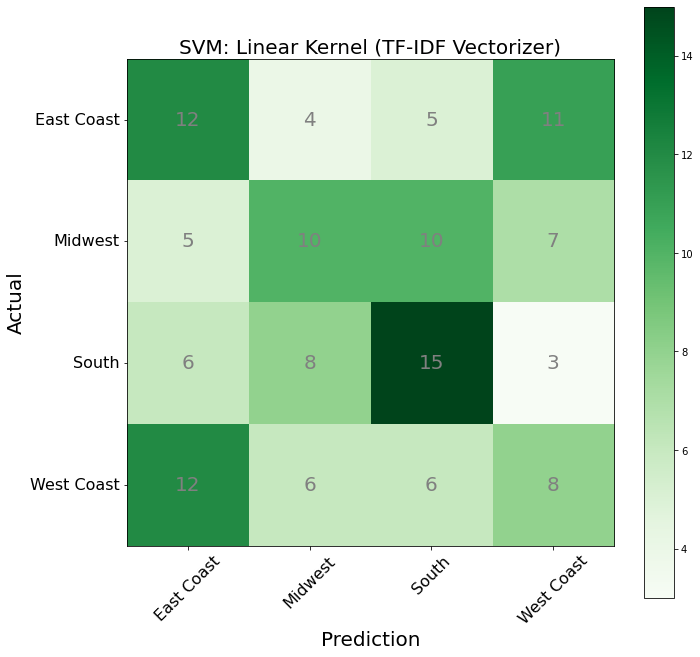

Overall Accuracy: 35.16%
Time Spent: 0.42 sec


In [412]:
### TF-IDF VECTORIZER + SVM MODEL (LINEAR KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)

SVM_Model_Linear = LinearSVC(C=1)

vecData = ssTfidfDF.drop(["LABEL"], axis=1)
vecLabels = ssTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Linear, vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
linCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Linear Kernel (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

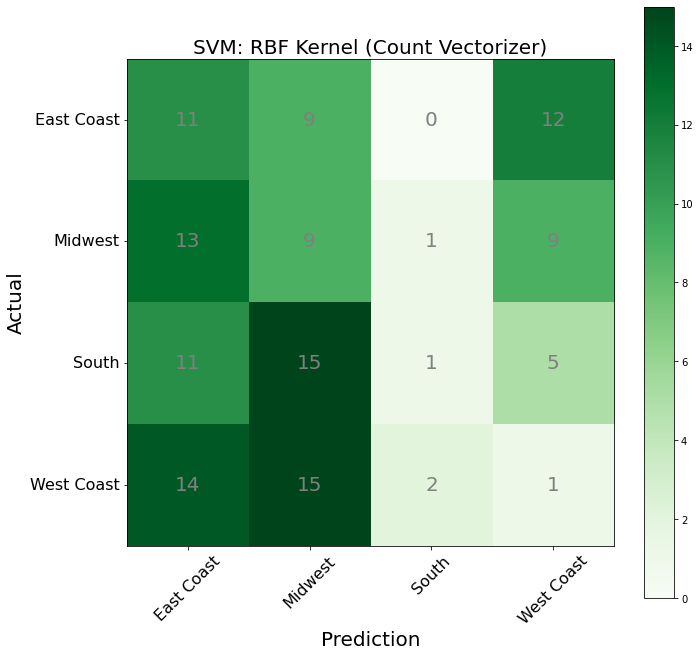

Overall Accuracy: 17.19%
Time Spent: 0.52 sec


In [413]:
### COUNT VECTORIZER + SVM MODEL (RBF KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Radial = sklearn.svm.SVC(C=1, kernel='rbf', verbose=True, gamma="auto")

vecData = ssCountDF.drop(["LABEL"], axis=1)
vecLabels = ssCountDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Radial, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
rbfCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: RBF Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

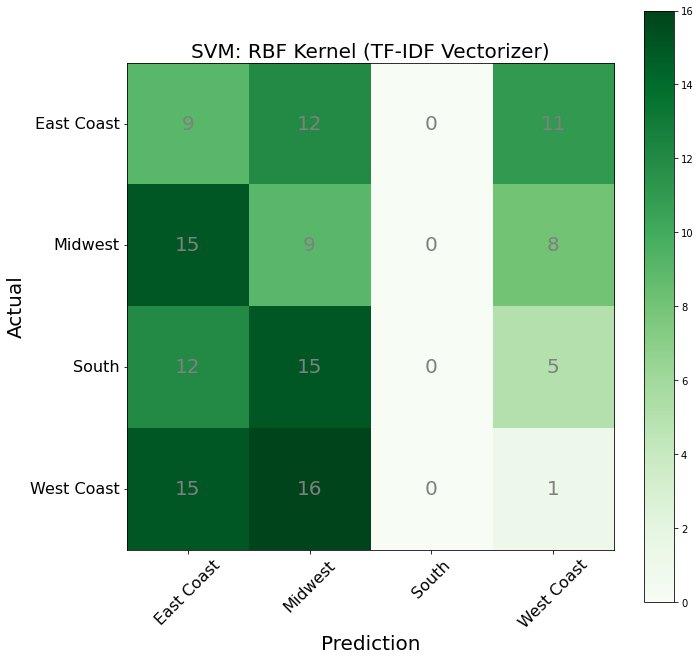

Overall Accuracy: 14.84%
Time Spent: 0.57 sec


In [414]:
### TF-IDF VECTORIZER + SVM MODEL (RBF KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Radial = sklearn.svm.SVC(C=1, kernel='rbf', verbose=True, gamma="auto")

vecData = ssTfidfDF.drop(["LABEL"], axis=1)
vecLabels = ssTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Radial, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
rbfCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: RBF Kernel (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

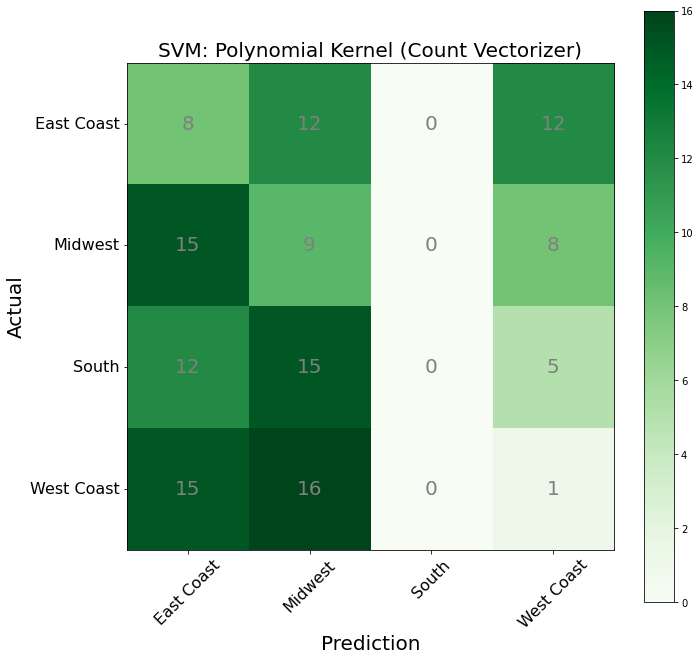

Overall Accuracy: 13.28%
Time Spent: 0.51 sec


In [415]:
### COUNT VECTORIZER + SVM MODEL (POLY KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Poly = sklearn.svm.SVC(C=1, kernel='poly', degree=2,
                           gamma="auto", verbose=True)

vecData = ssCountDF.drop(["LABEL"], axis=1)
vecLabels = ssCountDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Poly, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
polyCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Polynomial Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(conf_mat[0][0]+conf_mat[1][1])/sum(sum(conf_mat))))

timer_end()

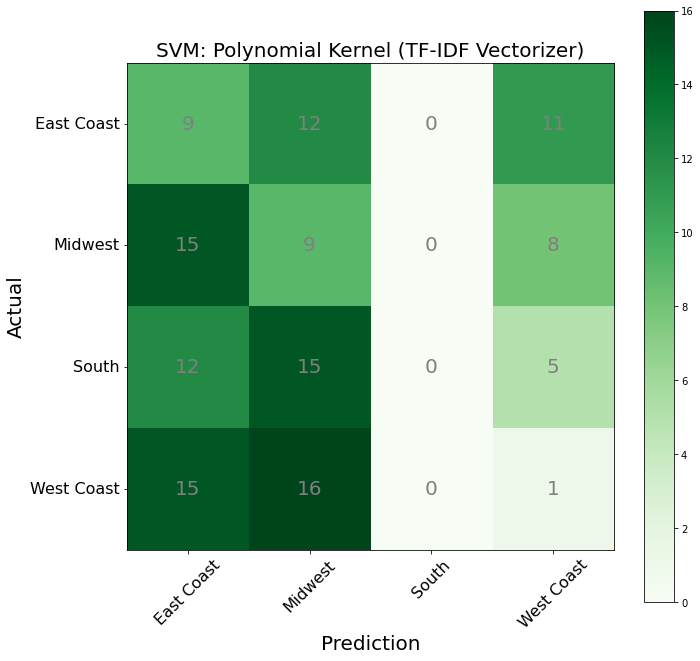

Overall Accuracy: 14.06%
Time Spent: 0.6 sec


In [416]:
### TF-IDF VECTORIZER + SVM MODEL (POLY KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Poly = sklearn.svm.SVC(C=1, kernel='poly', degree=2,
                           gamma="auto", verbose=True)

vecData = ssTfidfDF.drop(["LABEL"], axis=1)
vecLabels = ssTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Poly, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
polyCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Polynomial Kernel (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(conf_mat[0][0]+conf_mat[1][1])/sum(sum(conf_mat))))

timer_end()

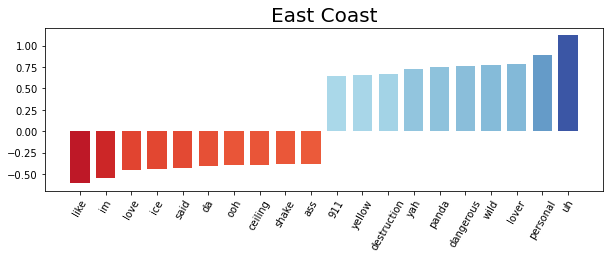

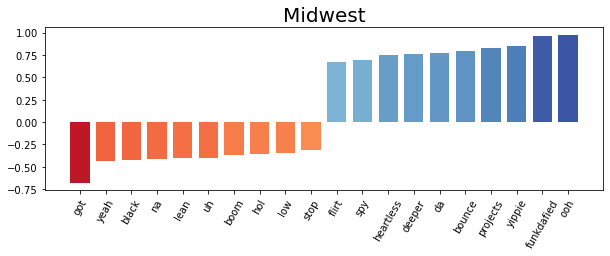

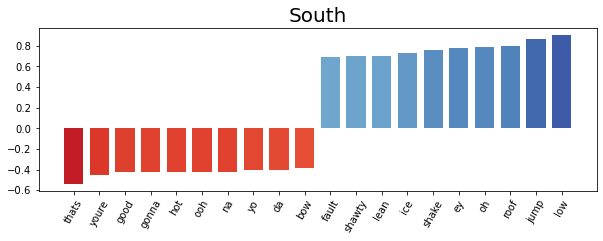

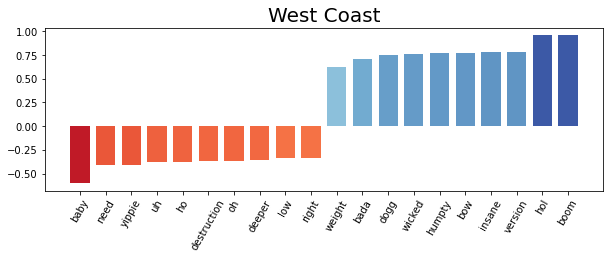

In [417]:
#Make sure to fit model to data before running function
vecData = ssTfidfDF.drop(["LABEL"], axis=1)
vecLabels = ssTfidfDF["LABEL"].copy()
SVM_Model_Linear.fit(vecData, vecLabels)

def plot_coefficients(classifier=SVM_Model_Linear, feature_names=vecData.columns, top_features=10):

    # Access the coefficients from classifier
    coef = classifier.coef_

    # Access the classes
    classes = classifier.classes_

    # Iterate the loop for number of classes
    for i in range(len(classes)):

        #print(classes[i])

        # Access the row containing the coefficients for this class
        class_coef = coef[i]


        # Below this, I have just replaced 'i' in your code with 'class_coef'
        # Pass this to get top and bottom features
        top_positive_coefficients = np.argsort(class_coef)[-top_features:]
        top_negative_coefficients = np.argsort(class_coef)[:top_features]

        # Concatenate the above two 
        top_coefficients = np.hstack([top_negative_coefficients, 
                                      top_positive_coefficients])
        # create plot
        plt.figure(figsize=(10, 3))
        plt.title(classes[i], fontsize = 20)

        #colors = ["red" if c < 0 else "blue" for c in class_coef[top_coefficients]]
        colorbalance = 0.1
        data_normalizer = mp.colors.Normalize(vmin = min(class_coef[top_coefficients])-colorbalance, vmax = max(class_coef[top_coefficients])+colorbalance)
        cmap = cm.RdYlBu
        plt.bar(np.arange(2 * top_features), 
                height = class_coef[top_coefficients],
                width = 0.75,
                color=cmap(data_normalizer(class_coef[top_coefficients])))
        feature_names = np.array(feature_names)

        # Here I corrected the start to 0 (Your code has 1, which shifted the labels)
        plt.xticks(np.arange(0, 2 * top_features), 
                   feature_names[top_coefficients], rotation=60, ha="center")
        plt.show()
plot_coefficients()

In [171]:
vecLabels

0      West Coast
1      West Coast
2      West Coast
3      West Coast
4      West Coast
          ...    
170       Midwest
171       Midwest
172       Midwest
173       Midwest
174       Midwest
Name: LABEL, Length: 175, dtype: object

In [184]:
vecData = ssTfidfDF.drop(["LABEL"], axis=1)
vecLabels = ssTfidfDF["LABEL"].copy()
SVM_Model_Linear.fit(vecData, vecLabels)
MODEL=SVM_Model_Linear
COLNAMES=vecData.columns
top_features=10

coef = MODEL.coef_
top_positive_coefficients = np.argsort(coef,axis=0)[-top_features:]
print(top_positive_coefficients)


[[3 3 3 ... 2 2 4]
 [1 0 1 ... 0 4 2]
 [4 4 4 ... 4 3 0]
 [0 1 0 ... 1 0 3]
 [2 2 2 ... 3 1 1]]


In [244]:
%run vectorize_years.py

In [329]:
yearsTfidfVecDF = pd.read_csv("years_tf_idf_vectorized.csv")
yearsCountVecDF = pd.read_csv("years_term_frequency_vectorized.csv")
yearsBinaryVecDF = pd.read_csv("years_binarized.csv")

In [330]:
## CREATE LIST OF THE TIME PERIODS INTERESTED IN ##

yearsList = []
for each in yearsCount['LABEL']:
    yearsList.append(each[:4])
yearsList = [int(i) for i in yearsList]
for i in range(0, len(yearsList)):
    if yearsList[i] < 1990:
        yearsList[i] = '1980s'
    elif yearsList[i] < 2000:
        yearsList[i] = '1990s'
    elif yearsList[i] < 2010:
        yearsList[i] = '2000s'
    else:
        yearsList[i] = '2010s'

print(yearsList[:10])

['2010s', '1980s', '1990s', '1990s', '1990s', '1990s', '2000s', '2000s', '2000s', '2000s']


In [346]:
## SUBSAMPLED BINARY VECTORIZED DATAFRAME ##

yearsBinDF = yearsBinaryVecDF.copy()
yearsBinDF['LABEL'] = yearsList

dropIndex = yearsBinDF[yearsBinDF['LABEL'].isin(['1980s'])].index
yearsBinDF = yearsBinDF.drop(dropIndex)
yearsLabels = yearsBinDF['LABEL'].copy()

small_dfs = []
for period in yearsLabels.unique():
    tempDF = yearsBinDF[yearsBinDF['LABEL'] == period].copy()
    subDF = tempDF.sample(min(yearsLabels.value_counts()), random_state = 42)
    small_dfs.append(subDF)

yearsBinDF = pd.concat(small_dfs, ignore_index = True)
yearsBinDF = yearsBinDF.loc[:, (yearsBinDF != 0).any(axis=0)]
yearsBinDF

,LABEL,01,04,06,10,100,100s,105,106,11,...,zombie,zone,zoned,zonin,zoning,zoom,zoomed,zooms,zoot,zoowap
0,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2000s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,2000s,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
222,2000s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,2000s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [347]:
## SUBSAMPLED COUNT VECTORIZED DATAFRAME ##

yearsCountDF = yearsCountVecDF.copy()
yearsCountDF['LABEL'] = yearsList

dropIndex = yearsCountDF[yearsCountDF['LABEL'].isin(['1980s'])].index
yearsCountDF = yearsCountDF.drop(dropIndex)
yearsLabels = yearsCountDF['LABEL'].copy()

small_dfs = []
for period in yearsLabels.unique():
    tempDF = yearsCountDF[yearsCountDF['LABEL'] == period].copy()
    subDF = tempDF.sample(min(yearsLabels.value_counts()), random_state = 42)
    small_dfs.append(subDF)

yearsCountDF = pd.concat(small_dfs, ignore_index = True)
yearsCountDF = yearsCountDF.loc[:, (yearsCountDF != 0).any(axis=0)]
yearsCountDF

,LABEL,01,04,06,10,100,100s,105,106,11,...,zombie,zone,zoned,zonin,zoning,zoom,zoomed,zooms,zoot,zoowap
0,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2010s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2000s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,2000s,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
222,2000s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,2000s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [348]:
## SUBSAMPLED TF-IDF VECTORIZED DATAFRAME ##

yearsTfidfDF = yearsTfidfVecDF.copy()
yearsTfidfDF['LABEL'] = yearsList

dropIndex = yearsTfidfDF[yearsTfidfDF['LABEL'].isin(['1980s'])].index
yearsTfidfDF = yearsTfidfDF.drop(dropIndex)
yearsLabels = yearsTfidfDF['LABEL'].copy()

small_dfs = []
for period in yearsLabels.unique():
    tempDF = yearsTfidfDF[yearsTfidfDF['LABEL'] == period].copy()
    subDF = tempDF.sample(min(yearsLabels.value_counts()), random_state = 42)
    small_dfs.append(subDF)

yearsTfidfDF = pd.concat(small_dfs, ignore_index = True)
yearsTfidfDF = yearsTfidfDF.loc[:, (yearsTfidfDF != 0).any(axis=0)]
yearsTfidfDF

,LABEL,01,04,06,10,100,100s,105,106,11,...,zombie,zone,zoned,zonin,zoning,zoom,zoomed,zooms,zoot,zoowap
0,2010s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2000s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,2000s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.027751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222,2000s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,2000s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


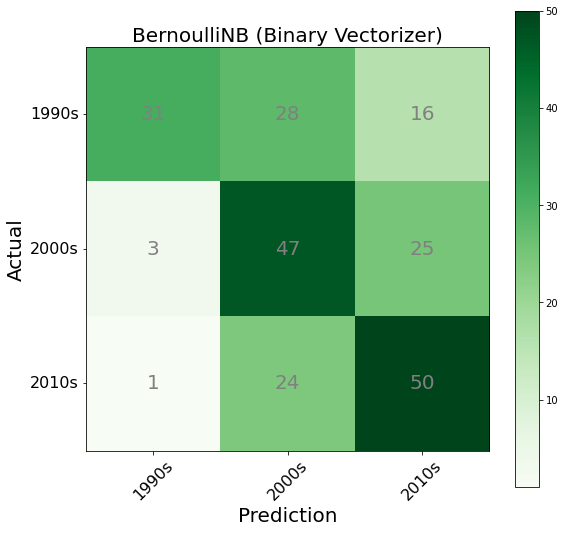

Overall Accuracy: 56.89%
Time Spent: 3.66 sec


In [440]:
### BINARY VECTORIZER + BERNOULLI NB MODEL ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = BernoulliNB(alpha=1)

vecData = yearsBinDF.drop(["LABEL"], axis=1)
vecLabels = yearsBinDF['LABEL']

y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('BernoulliNB (Binary Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

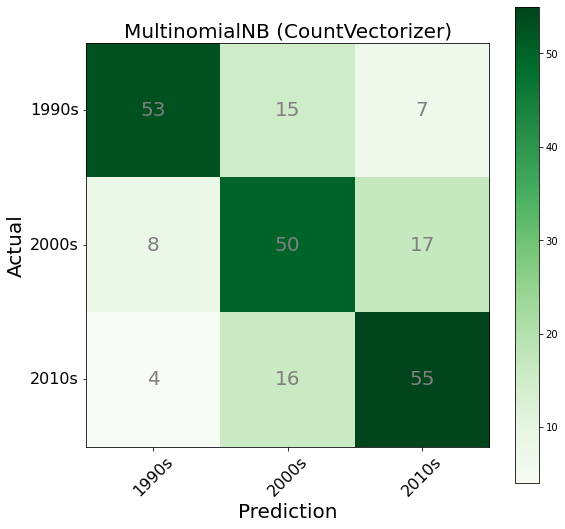

Overall Accuracy: 70.22%
Time Spent: 4.62 sec


In [441]:
### COUNT VECTORIZER + MULTINOMIAL NB MODEL ###
timer_start()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = NB(alpha=1)

vecData = yearsCountDF.drop(["LABEL"], axis=1)
vecLabels = yearsCountDF["LABEL"].copy()

y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('MultinomialNB (CountVectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

In [429]:
timer_start()

nbmodel = NB(alpha=1)

vecData = yearsTfidfDF.drop(["LABEL"], axis=1)
vecLabels = yearsTfidfDF["LABEL"].copy()
temp = pd.DataFrame(columns = ['random state', 'accuracy'])

for state in range(0,10):
    cv = KFold(n_splits=5, random_state=state, shuffle=True)

    y_pred = cross_val_predict(nbmodel, vecData, vecLabels, 
                               cv=cv, n_jobs=-1)
    linCountPred = y_pred
    conf_mat = confusion_matrix(vecLabels, y_pred, 
                                #normalize = 'all'
                               )
    temp = temp.append({'random state': state, 'accuracy': 100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))}, ignore_index = True)


timer_end()
temp

Time Spent: 4.34 sec


,random state,accuracy
0,0.0,56.444444
1,1.0,55.555556
2,2.0,43.111111
3,3.0,59.111111
4,4.0,63.555556
5,5.0,54.666667
6,6.0,52.888889
7,7.0,48.888889
8,8.0,58.222222
9,9.0,53.333333


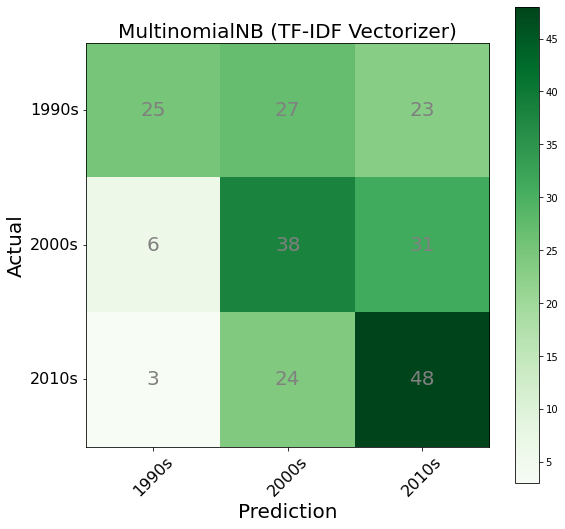

Overall Accuracy: 49.33%
Time Spent: 0.58 sec


In [443]:
### TF-IDF VECTORIZER + MULTINOMIAL NB MODEL ###
timer_start()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
nbmodel = NB(alpha=1)

vecData = yearsTfidfDF.drop(["LABEL"], axis=1)
vecLabels = yearsTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(nbmodel, vecData, vecLabels, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )
class_names = vecLabels.unique().tolist()
class_names.sort()
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('MultinomialNB (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))
timer_end()

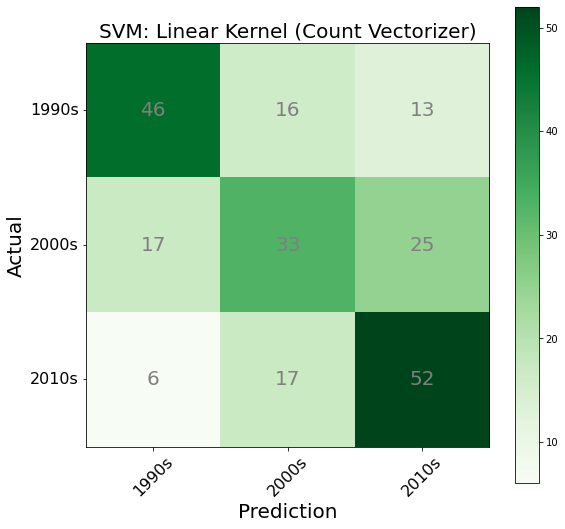

Overall Accuracy: 58.22%
Time Spent: 0.71 sec


In [444]:
### COUNT VECTORIZER + SVM MODEL (LINEAR KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)

SVM_Model_Linear = LinearSVC(C=1)

vecData = yearsCountDF.drop(["LABEL"], axis=1)
vecLabels = yearsCountDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Linear, vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
linCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Linear Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

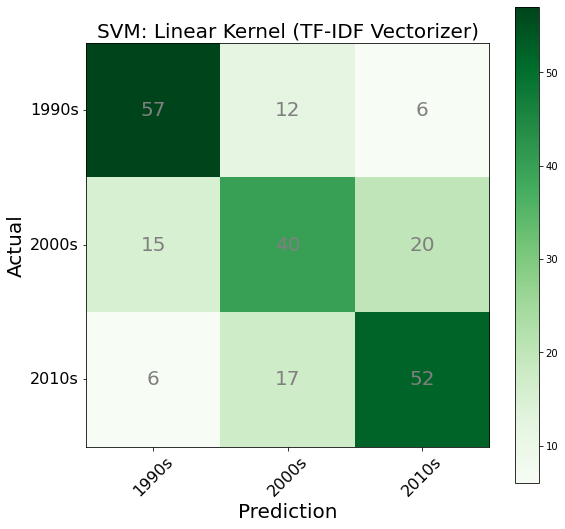

Overall Accuracy: 66.22%
Time Spent: 0.57 sec


In [445]:
### TF-IDF VECTORIZER + SVM MODEL (LINEAR KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)

SVM_Model_Linear = LinearSVC(C=1)

vecData = yearsTfidfDF.drop(["LABEL"], axis=1)
vecLabels = yearsTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Linear, vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
linCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Linear Kernel (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

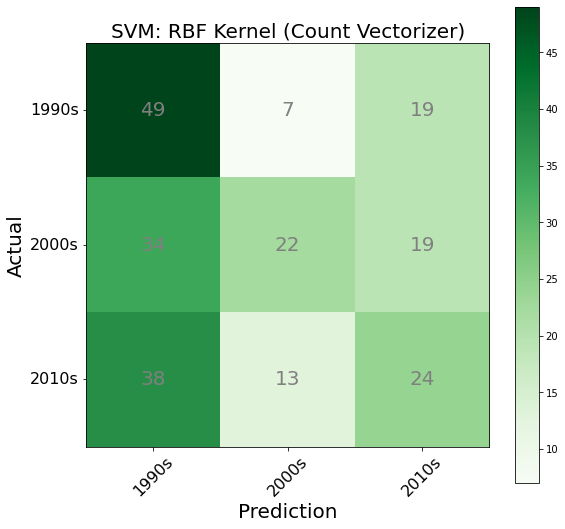

Overall Accuracy: 42.22%
Time Spent: 1.12 sec


In [446]:
### COUNT VECTORIZER + SVM MODEL (RBF KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Radial = sklearn.svm.SVC(C=1, kernel='rbf', verbose=True, gamma="auto")

vecData = yearsCountDF.drop(["LABEL"], axis=1)
vecLabels = yearsCountDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Radial, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
rbfCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: RBF Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

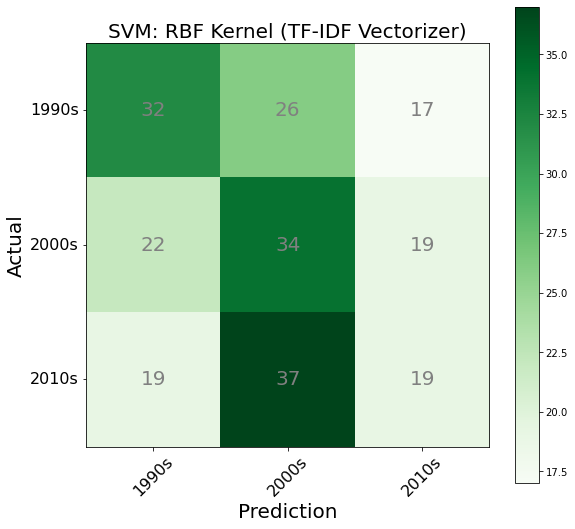

Overall Accuracy: 37.78%
Time Spent: 1.06 sec


In [447]:
### TF-IDF VECTORIZER + SVM MODEL (RBF KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Radial = sklearn.svm.SVC(C=1, kernel='rbf', verbose=True, gamma="auto")

vecData = yearsTfidfDF.drop(["LABEL"], axis=1)
vecLabels = yearsTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Radial, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
rbfCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: RBF Kernel (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(DiagonalSum(conf_mat))/sum(sum(conf_mat))))

timer_end()

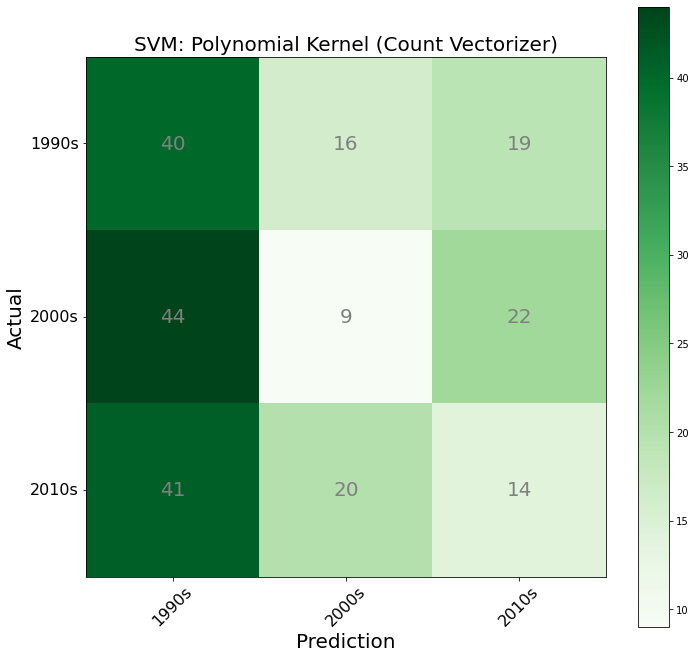

Overall Accuracy: 21.78%
Time Spent: 1.23 sec


In [363]:
### COUNT VECTORIZER + SVM MODEL (POLY KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Poly = sklearn.svm.SVC(C=1, kernel='poly', degree=2,
                           gamma="auto", verbose=True)

vecData = yearsCountDF.drop(["LABEL"], axis=1)
vecLabels = yearsCountDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Poly, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
polyCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Polynomial Kernel (Count Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(conf_mat[0][0]+conf_mat[1][1])/sum(sum(conf_mat))))

timer_end()

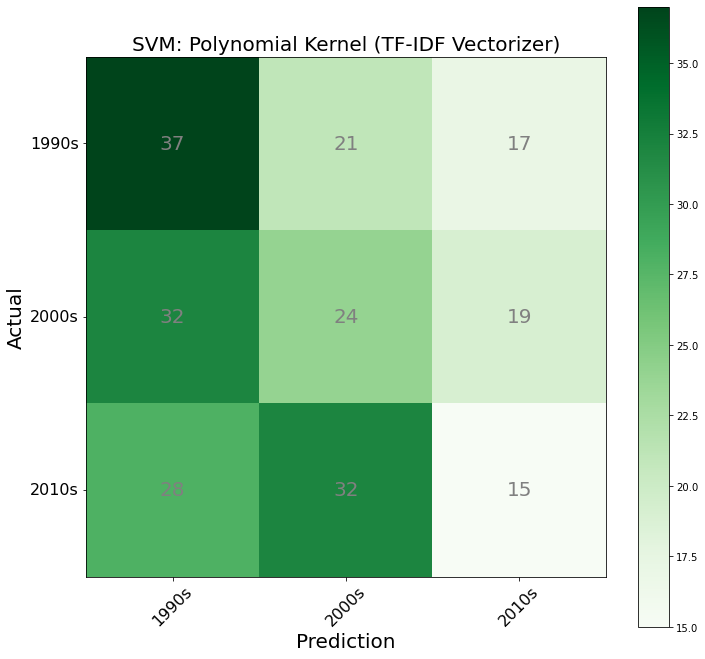

Overall Accuracy: 27.11%
Time Spent: 1.3 sec


In [364]:
### TF-IDF VECTORIZER + SVM MODEL (POLY KERNEL) ###
timer_start()

cv = KFold(n_splits=5, random_state=42, shuffle=True)
SVM_Model_Poly = sklearn.svm.SVC(C=1, kernel='poly', degree=2,
                           gamma="auto", verbose=True)

vecData = yearsTfidfDF.drop(["LABEL"], axis=1)
vecLabels = yearsTfidfDF["LABEL"].copy()

y_pred = cross_val_predict(SVM_Model_Poly, 
                           vecData, vecLabels, 
                           cv=cv, n_jobs=-1)
polyCountPred = y_pred
conf_mat = confusion_matrix(vecLabels, y_pred, 
                            #normalize = 'all'
                           )

plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_mat, classes=class_names)
plt.title('SVM: Polynomial Kernel (TF-IDF Vectorizer)', fontsize = 20)
plt.show()
print('Overall Accuracy: %.2f%%' 
      % (100*(conf_mat[0][0]+conf_mat[1][1])/sum(sum(conf_mat))))

timer_end()

[-5.18817111 -5.10333223 -5.07969047 -5.00758718 -4.96920293 -4.93627815
 -4.88883842 -4.71881874 -4.37492876 -4.28024863]
[-10.44566648 -10.44566648 -10.44566648 -10.44566648 -10.44566648
 -10.44566648 -10.44566648 -10.44566648 -10.44566648 -10.44566648]


C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


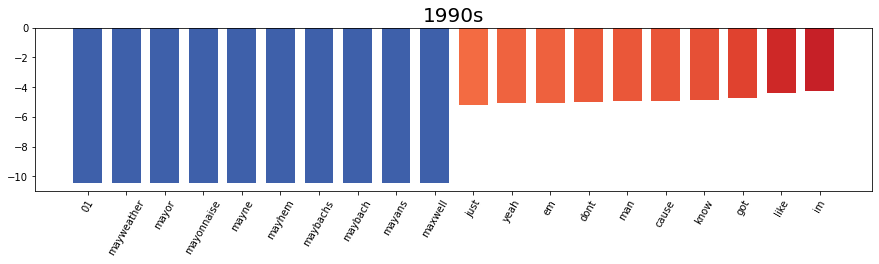

[-5.14890544 -5.1394267  -5.0888412  -4.94305339 -4.90876431 -4.80228083
 -4.65537131 -4.62671606 -4.14164293 -3.96659413]
[-10.49601297 -10.49601297 -10.49601297 -10.49601297 -10.49601297
 -10.49601297 -10.49601297 -10.49601297 -10.49601297 -10.49601297]


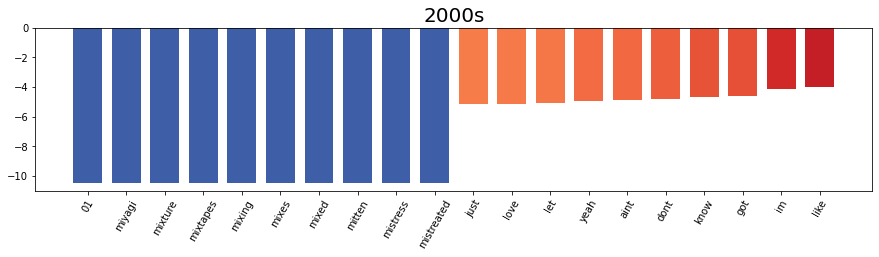

[-5.14524232 -4.84383577 -4.78255534 -4.61846422 -4.61254704 -4.56925023
 -4.54139328 -4.25028302 -4.19050427 -3.79085877]
[-10.43854715 -10.43854715 -10.43854715 -10.43854715 -10.43854715
 -10.43854715 -10.43854715 -10.43854715 -10.43854715 -10.43854715]


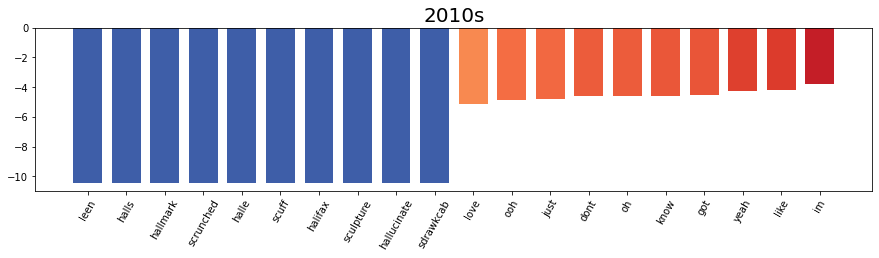

In [430]:
#Make sure to fit model to data before running function
vecData = yearsCountDF.drop(["LABEL"], axis=1)
vecLabels = yearsCountDF["LABEL"].copy()
nbmodel.fit(vecData, vecLabels)

def plot_coefficients(classifier=nbmodel, feature_names=vecData.columns, top_features=10):

    # Access the coefficients from classifier
    coef = classifier.coef_

    # Access the classes
    classes = classifier.classes_

    # Iterate the loop for number of classes
    for i in range(len(classes)):

        #print(classes[i])

        # Access the row containing the coefficients for this class
        class_coef = coef[i]

        # Below this, I have just replaced 'i' in your code with 'class_coef'
        # Pass this to get top and bottom features
        top_positive_coefficients = np.argsort(class_coef)[-top_features:]
        top_negative_coefficients = np.argsort(class_coef)[:top_features]
        print(class_coef[top_positive_coefficients])
        print(class_coef[top_negative_coefficients])

        # Concatenate the above two 
        top_coefficients = np.hstack([top_negative_coefficients, 
                                      top_positive_coefficients])
        # create plot
        plt.figure(figsize=(15, 3))
        plt.title(classes[i], fontsize = 20)

        #colors = ["red" if c < 0 else "blue" for c in class_coef[top_coefficients]]
        colorbalance = 0.5
        data_normalizer = mp.colors.Normalize(vmin = min(class_coef[top_coefficients])-colorbalance, 
                                              vmax = max(class_coef[top_coefficients])+colorbalance)
        cmap = cm.RdYlBu_r
        plt.bar(np.arange(2 * top_features), 
                height = class_coef[top_coefficients],
                width = 0.75,
                color=cmap(data_normalizer(class_coef[top_coefficients])))
        feature_names = np.array(feature_names)

        # Here I corrected the start to 0 (Your code has 1, which shifted the labels)
        plt.xticks(np.arange(0, 2 * top_features), 
                   feature_names[top_coefficients], rotation=60, ha="center")
        plt.show()
plot_coefficients()

[0.70460332 0.71027865 0.71335178 0.71475914 0.73476788 0.74558062
 0.80903442 0.82097345 0.96008791 1.18383517]
[-0.8684014  -0.8433216  -0.80330375 -0.7116314  -0.70418191 -0.70375324
 -0.66648233 -0.59254821 -0.58173678 -0.56017701]


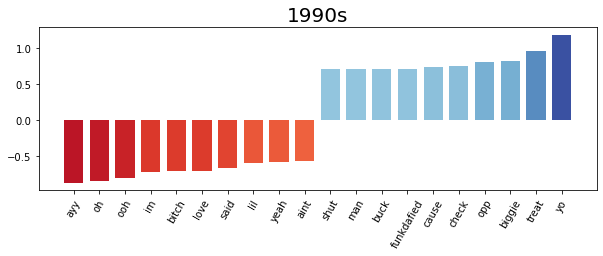

[0.73877551 0.74153441 0.7438366  0.74745405 0.76907604 0.78609338
 0.79687961 0.81663192 0.85284974 0.92869573]
[-0.64495117 -0.64133301 -0.59305772 -0.58263984 -0.57896061 -0.54253951
 -0.53083398 -0.52293373 -0.51708249 -0.50838191]


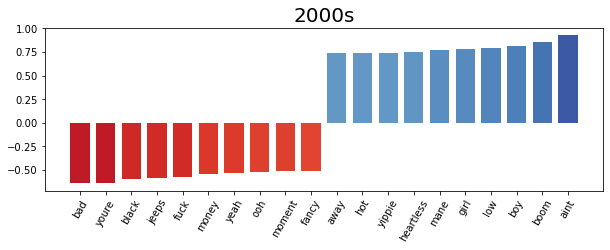

[0.78518796 0.79367182 0.8076318  0.81887046 0.89863034 0.91994631
 0.94829375 1.06858396 1.13515756 1.27985869]
[-0.96901146 -0.64147324 -0.61872741 -0.59850673 -0.53468006 -0.52600055
 -0.5013644  -0.45604976 -0.44630461 -0.43800843]


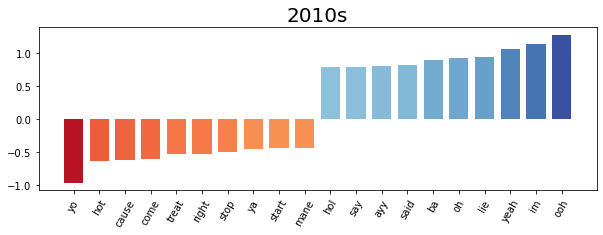

In [392]:
#Make sure to fit model to data before running function
vecData = yearsTfidfDF.drop(["LABEL"], axis=1)
vecLabels = yearsTfidfDF["LABEL"].copy()
SVM_Model_Linear.fit(vecData, vecLabels)

def plot_coefficients(classifier=SVM_Model_Linear, feature_names=vecData.columns, top_features=10):

    # Access the coefficients from classifier
    coef = classifier.coef_

    # Access the classes
    classes = classifier.classes_

    # Iterate the loop for number of classes
    for i in range(len(classes)):

        #print(classes[i])

        # Access the row containing the coefficients for this class
        class_coef = coef[i]

        # Below this, I have just replaced 'i' in your code with 'class_coef'
        # Pass this to get top and bottom features
        top_positive_coefficients = np.argsort(class_coef)[-top_features:]
        top_negative_coefficients = np.argsort(class_coef)[:top_features]
        print(class_coef[top_positive_coefficients])
        print(class_coef[top_negative_coefficients])

        # Concatenate the above two 
        top_coefficients = np.hstack([top_negative_coefficients, 
                                      top_positive_coefficients])
        # create plot
        plt.figure(figsize=(10, 3))
        plt.title(classes[i], fontsize = 20)

        #colors = ["red" if c < 0 else "blue" for c in class_coef[top_coefficients]]
        colorbalance = 0.1
        data_normalizer = mp.colors.Normalize(vmin = min(class_coef[top_coefficients])-colorbalance, 
                                              vmax = max(class_coef[top_coefficients])+colorbalance)
        cmap = cm.RdYlBu
        plt.bar(np.arange(2 * top_features), 
                height = class_coef[top_coefficients],
                width = 0.75,
                color=cmap(data_normalizer(class_coef[top_coefficients])))
        feature_names = np.array(feature_names)

        # Here I corrected the start to 0 (Your code has 1, which shifted the labels)
        plt.xticks(np.arange(0, 2 * top_features), 
                   feature_names[top_coefficients], rotation=60, ha="center")
        plt.show()
plot_coefficients()